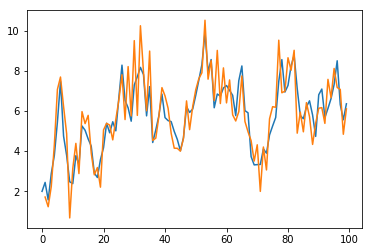

In [1]:
%matplotlib inline

from ssm.dglm import NormalDLM
from ssm.univariatestructure import UnivariateStructure
import numpy as np
from scipy.stats import multivariate_normal as mvn

lc = UnivariateStructure.locally_constant(1.4)

ndlm = NormalDLM(structure=lc, V=1.4)

# the initial state prior
m0 = np.array([0])
C0 = np.matrix([[1]])
state0 = mvn(m0, C0).rvs()

states = [state0]

for t in range(1, 100):
    states.append(ndlm.state(states[t-1]))
    
obs = [None]
for t in range(1, 100):
    obs.append(ndlm.observation(states[t]))
    
import matplotlib.pyplot as plt
plt.plot(range(100), states)
plt.plot(range(100), obs)

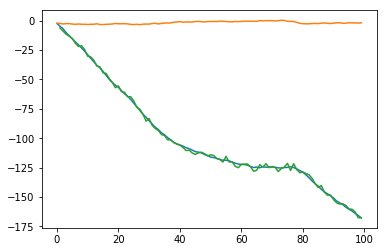

In [2]:
W = np.matrix([[0.1, 0], [0, 0.1]])
ll = UnivariateStructure.locally_linear(W)

ndlm = NormalDLM(structure=ll, V=2.5)

# the initial state prior
m0 = np.array([0, -1])
C0 = np.identity(2)
state0 = mvn(m0, C0).rvs()

states = [state0]

for t in range(1, 100):
    states.append(ndlm.state(states[t-1]))
    
obs = [None]
for t in range(1, 100):
    obs.append(ndlm.observation(states[t]))
    
import matplotlib.pyplot as plt
plt.plot(range(100), states)
plt.plot(range(100), obs)


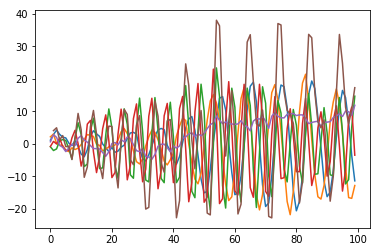

In [3]:
fourier = UnivariateStructure.cyclic_fourier(period=10, harmonics=2, W=np.identity(4))

ndlm_comp = NormalDLM(structure=(fourier + lc), V=2.5)

# the initial state prior
m0 = np.array([0, 0, 0, 0, 0])
C0 = np.identity(5)
state0 = np.random.multivariate_normal(m0, C0)

states = [state0]

for t in range(1, 100):
    states.append(ndlm_comp.state(states[t-1]))
    
obs = [None]
for t in range(1, 100):
    obs.append(ndlm_comp.observation(states[t]))
    
import matplotlib.pyplot as plt
plt.plot(range(100), states)
plt.plot(range(100), obs)
